Upon acquiring advanced econometric and programming skills during our master's studies, we decided to enhance the code written over two years ago, aiming for maximum automation and improved econometric accuracy.  

Please note that our primary intention was not to perfect this model in terms of the approach taken, such as using superior or more recent data, or potentially more suitable models like panel data models. Our primary objective in devising this approach was automation and reproducibility of results, and we primarily directed our attention towards these aspects.

In [39]:
import os
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import PowerTransformer
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from statsmodels.compat import lzip
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import pandas_profiling
import warnings
warnings.filterwarnings("ignore")

import statistics as stats
from pandas_profiling import ProfileReport
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from stargazer.stargazer import Stargazer
from statsmodels.compat import lzip
from statsmodels.stats import diagnostic as ssd
from scipy import stats as scys

In [28]:
os.getcwd()
df = pd.read_excel("Source files/baza_noworodki.xlsx")
df.head()

,noworodki,ochrona_zdrowia,GDPpc,GDP,populacja,labor_force,death_rate,urban_pop,turysci,HIV
0,8.5,5.262714,5284.380184,1.514702e+10,2866376.0,1318022,7.898,60.319,5340000,0
1,20.4,6.218427,4153.733978,1.754057e+11,42228429.0,12173459,4.716,72.629,2657000,0
2,51.9,2.549005,3289.646664,1.013532e+11,30809762.0,12705486,8.190,65.514,218000,1
3,8.7,9.624540,11633.498009,5.176267e+11,44494502.0,20551682,7.609,91.870,6942000,1
4,11.0,10.025390,4220.490277,1.245794e+10,2951776.0,1303093,9.857,63.149,1652000,0


In the initial step, we computed the Variance Inflation Factor (VIF) and eliminated collinear variables (VIF > 10) from the model.  

Despite the VIF coefficient being relatively low, we considered that the values for GDP and GDP per capita should not both remain in the model. Consequently, we also removed the GDP variable.

In [29]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
Xx = df.copy()

def calculate_vif(Xx):
    vif_data = pd.DataFrame()
    vif_data["feature"] = Xx.columns
    vif_data["VIF"] = [variance_inflation_factor(Xx.values, i)
                            for i in range(len(Xx.columns))]
    lider = vif_data.sort_values(by = 'VIF', ascending= False).iloc[0,]
    print(lider, vif_data)
    if (lider.VIF > 10):
        col = lider.feature
        Xx = Xx.drop(columns= [col])
        calculate_vif(Xx)
    
    
vif_data = calculate_vif(Xx)

print(vif_data)


feature    labor_force
VIF            30.6245
Name: 5, dtype: object            feature        VIF
0        noworodki   2.789237
1  ochrona_zdrowia  12.060030
2            GDPpc   3.129436
3              GDP   3.451977
4        populacja  26.720347
5      labor_force  30.624500
6       death_rate   8.099559
7        urban_pop   9.358728
8          turysci   2.703658
9              HIV   2.297961
feature    ochrona_zdrowia
VIF              11.856304
Name: 1, dtype: object            feature        VIF
0        noworodki   2.781260
1  ochrona_zdrowia  11.856304
2            GDPpc   3.097999
3              GDP   2.849485
4        populacja   1.832936
5       death_rate   8.057869
6        urban_pop   9.217044
7          turysci   2.697108
8              HIV   2.297613
feature    urban_pop
VIF         7.221372
Name: 5, dtype: object       feature       VIF
0   noworodki  2.733857
1       GDPpc  3.011122
2         GDP  2.602443
3   populacja  1.752073
4  death_rate  5.786262
5   urban_pop  

In [41]:
df = df.drop(columns = ['ochrona_zdrowia',  'labor_force'])
df = df.drop(columns = ['GDP'])

In [43]:
report = pandas_profiling.ProfileReport(df)
report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Subsequently, instead of the random logarithmization of numerical variables, we calculated the values of the Shapiro-Wilk test for variables both before and after logarithmization. We retained in our database those variables for which the p-value was higher (comparing before versus after logarithmization).

In [46]:
# shapiro test for pre-log variables
statss = []
for column in df.columns:
  stat, p = shapiro(df[column])
  print('Shapiro-Wilk for {}: {:.3f}, p-value: {:.3f}'.format(column, stat, p))
  statss.append(p)

# shapiro test for logged variables
def logsy(df, cols=[]):
    for col in cols:
        df['log_'+str(col)] = np.log(df[col])
        df = df.drop(columns=[col])
    return df
    

print(f'-'*50)

df1 = df.copy()
cols = df1.columns
df1 = logsy(df1,cols)

statss1 = []
for column in df1.columns:
  stat, p = shapiro(df1[column])
  print('Shapiro-Wilk for {}: {:.3f}, p-value: {:.3f}'.format(column, stat, p))
  statss1.append(p)

Shapiro-Wilk for noworodki: 0.790, p-value: 0.000
Shapiro-Wilk for GDPpc: 0.756, p-value: 0.000
Shapiro-Wilk for populacja: 0.241, p-value: 0.000
Shapiro-Wilk for death_rate: 0.973, p-value: 0.008
Shapiro-Wilk for urban_pop: 0.965, p-value: 0.001
Shapiro-Wilk for turysci: 0.608, p-value: 0.000
Shapiro-Wilk for HIV: 0.605, p-value: 0.000
--------------------------------------------------
Shapiro-Wilk for log_noworodki: 0.970, p-value: 0.004
Shapiro-Wilk for log_GDPpc: 0.979, p-value: 0.033
Shapiro-Wilk for log_populacja: 0.990, p-value: 0.420
Shapiro-Wilk for log_death_rate: 0.934, p-value: 0.000
Shapiro-Wilk for log_urban_pop: 0.897, p-value: 0.000
Shapiro-Wilk for log_turysci: 0.980, p-value: 0.042
Shapiro-Wilk for log_HIV: nan, p-value: 1.000


In [50]:
# variables with lower pvalues will remain in the dataframe 
df3 = df.copy()
for i in range(len(statss)):
    x = (statss1[i] - statss[i])
    if(x>0):
        df3.iloc[:,i] = df1.iloc[:,i]
        df3 = df3.rename({df3.columns[i]:df1.columns[i]}, axis = 'columns')
        print(df1.columns[i],x )
    
df3['HIV'] = df['HIV'] 
df3 = df3.drop(columns=['log_HIV'])
display(df.head())
df3.head()

log_noworodki 0.004412224515022746
log_GDPpc 0.03255191072811142
log_populacja 0.42008495330810547
log_turysci 0.04226090759038923
log_HIV 1.0


,noworodki,GDPpc,populacja,death_rate,urban_pop,turysci,HIV
0,8.5,5284.380184,2866376.0,7.898,60.319,5340000,0
1,20.4,4153.733978,42228429.0,4.716,72.629,2657000,0
2,51.9,3289.646664,30809762.0,8.190,65.514,218000,1
3,8.7,11633.498009,44494502.0,7.609,91.870,6942000,1
4,11.0,4220.490277,2951776.0,9.857,63.149,1652000,0


,log_noworodki,log_GDPpc,log_populacja,death_rate,urban_pop,log_turysci,HIV
0,2.140066,8.572511,14.868559,7.898,60.319,15.490736,0
1,3.015535,8.331763,17.558604,4.716,72.629,14.792708,0
2,3.949319,8.098535,17.243342,8.190,65.514,12.292250,1
3,2.163323,9.361644,17.610876,7.609,91.870,15.753100,1
4,2.397895,8.347707,14.897918,9.857,63.149,14.317497,0


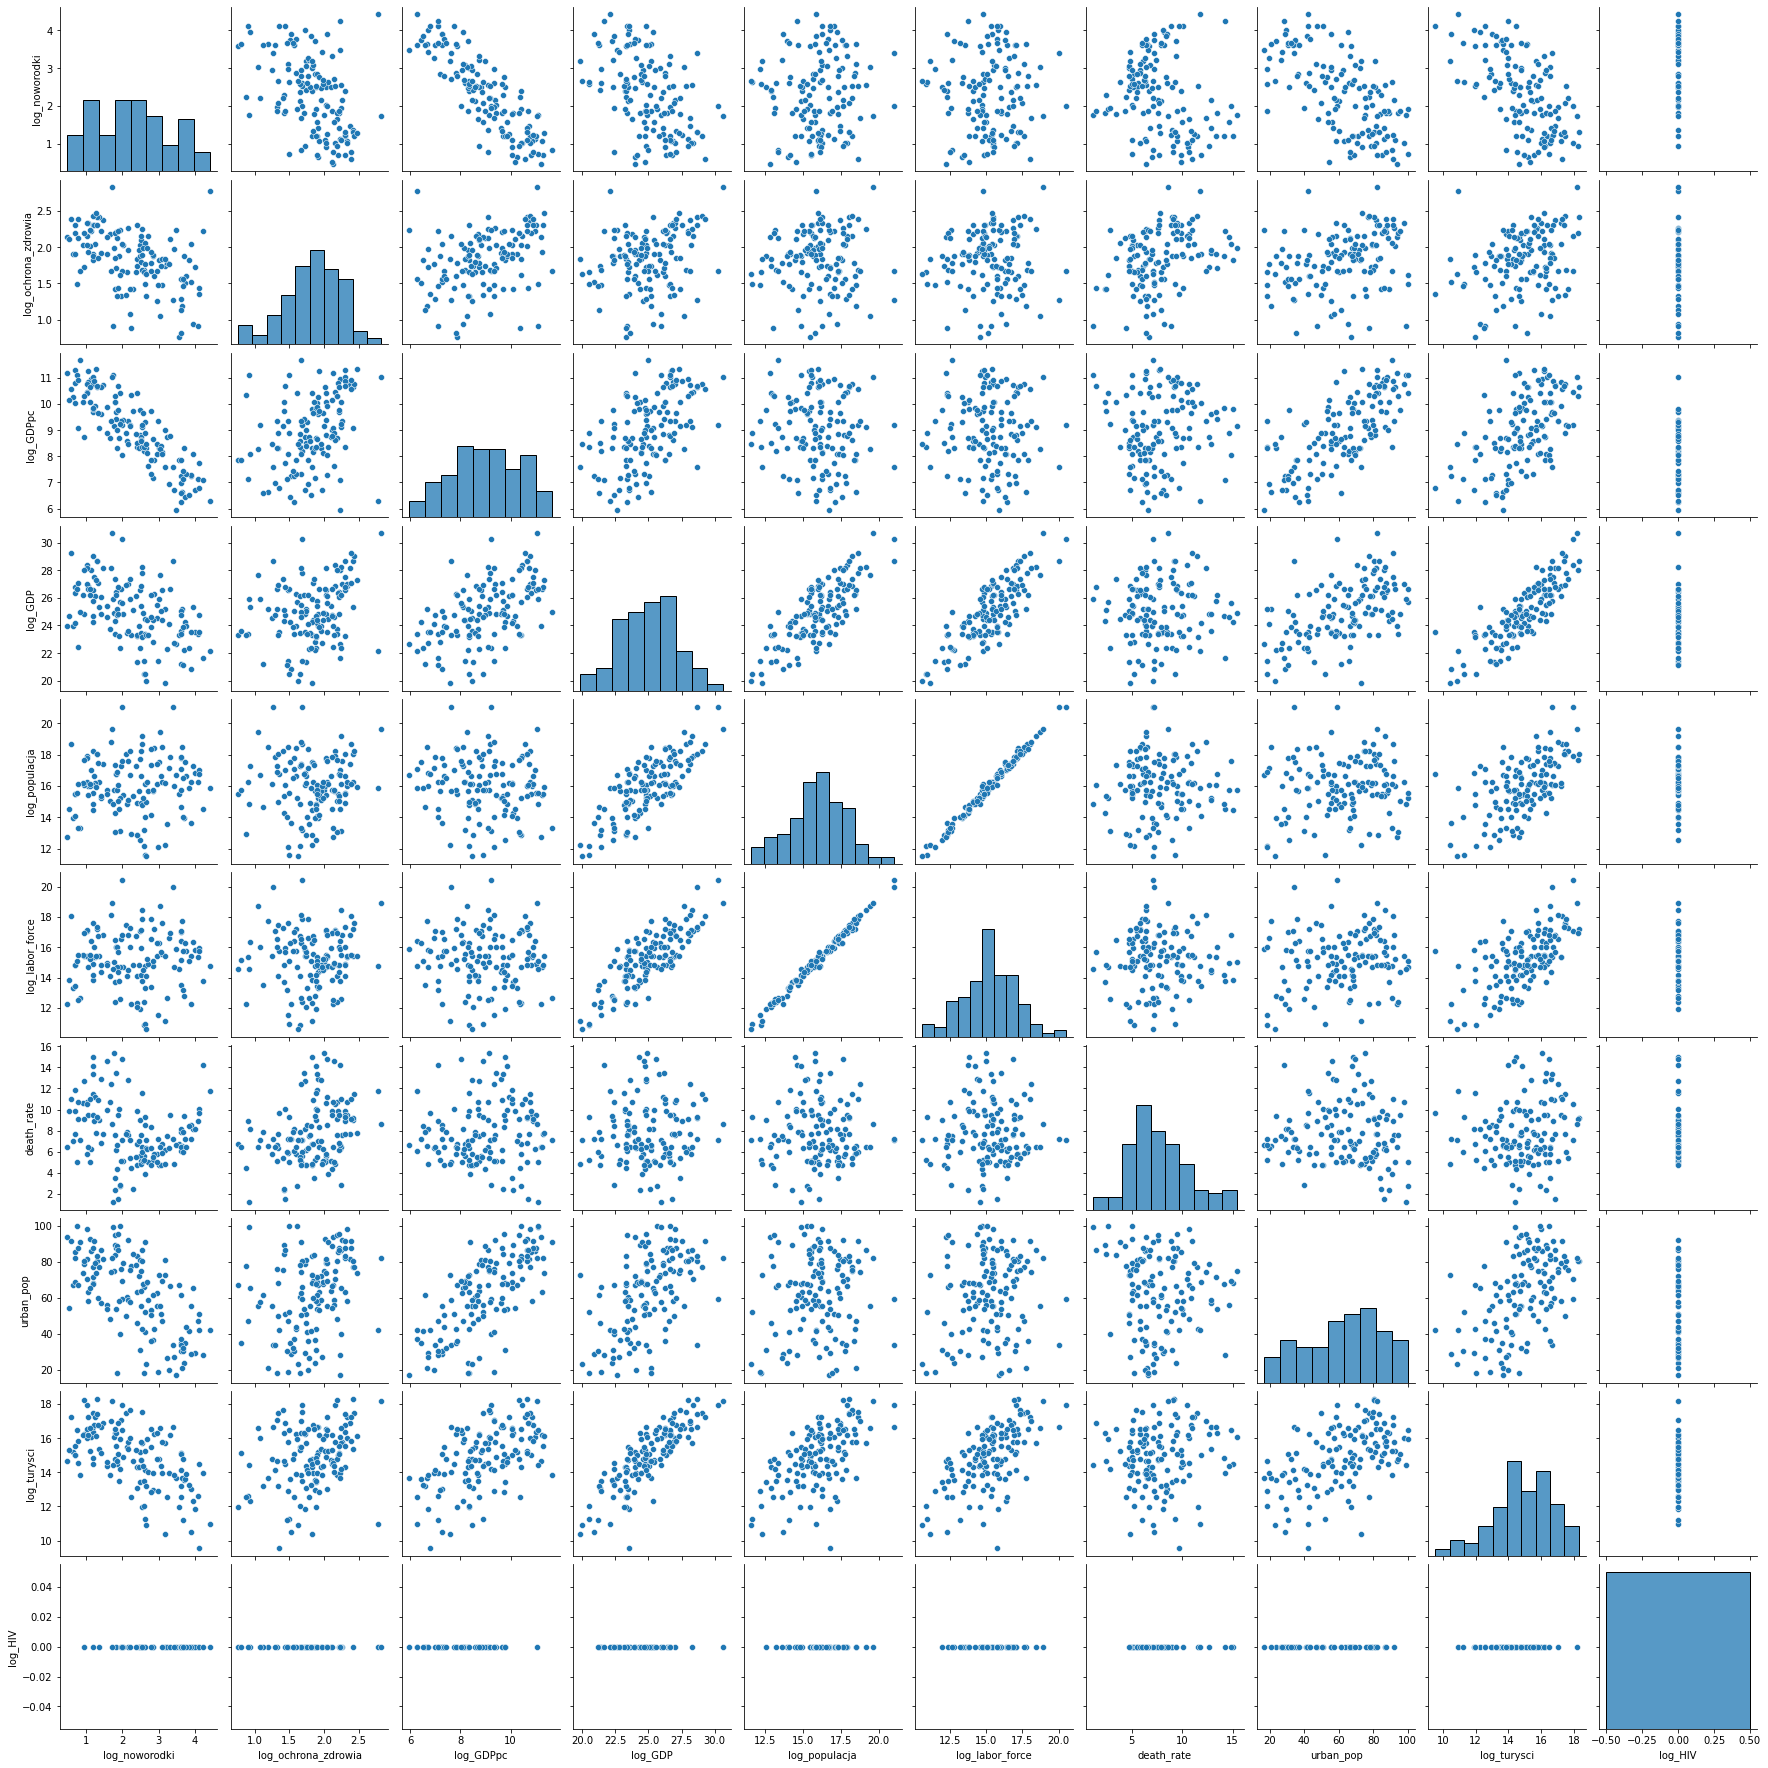

In [34]:
sns.pairplot(df3)

In [36]:
df3.columns

Index(['log_noworodki', 'log_ochrona_zdrowia', 'log_GDPpc', 'log_GDP',
       'log_populacja', 'log_labor_force', 'death_rate', 'urban_pop',
       'log_turysci', 'log_HIV'],
      dtype='object')

Following that, we created code which automatically carries out a general-to-specific procedure for the processed database, thereby deriving the final form of the model:

In [51]:
models = {}
models_summary = {}
drop_order = ['Intercept']
def GTS_iter(df):
    X = df3.drop(columns=['log_noworodki'])
    y = df3['log_noworodki']

    def model_creator(X,y):
        string = ''
        for col in X.columns:
            string = string + str(col) + '+'
        return str(y.name)+'~' + string[:-1]
    
    model_formula = model_creator(X,y)
    X["log_noworodki"] = y
    model= smf.ols(model_formula , X).fit()

    return(model)

model = GTS_iter(df3)
models['model_1'] = model
models_summary['model_1'] = model.summary()
i = 1

while model.pvalues.max() > 0.05:
    i+=1
    max_pvalue = model.pvalues.idxmax()
    if((max_pvalue == 'Intercept')):
        if((model.pvalues.sort_values(ascending = False)[1] > 0.05)):
            max_pvalue = model.pvalues.sort_values(ascending = False).index[1]
        else:
            break
    df3 = df3.drop(columns=[max_pvalue], axis = 1)
    drop_order.append(max_pvalue)
    model = GTS_iter(df3)
    models_summary[f'model_{i}'] = model.summary()
    models[f'model_{i}'] = model
    
for col in df3.drop(columns=["log_noworodki"]).columns:    
    drop_order.append(col)
models



{'model_1': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x16d191b2cd0>,
 'model_2': <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x16d22a59ca0>}

In [53]:
from IPython.display import HTML
stargazer = Stargazer(list(models.values()))
stargazer.sig_levels = [0.05, 0.01, 0.001]
custom_cols = {col: col.capitalize() for col in drop_order}

html_output = stargazer.render_html()
print(html_output)
HTML(html_output)

<table style="text-align:center"><tr><td colspan="3" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left"></td><td colspan="2"><em>Dependent variable:log_noworodki</em></td></tr><tr><td style="text-align:left"></td><tr><td style="text-align:left"></td><td>(1)</td><td>(2)</td></tr><tr><td colspan="3" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">HIV</td><td>0.276<sup>**</sup></td><td>0.266<sup>**</sup></td></tr><tr><td style="text-align:left"></td><td>(0.092)</td><td>(0.093)</td></tr><tr><td style="text-align:left">Intercept</td><td>7.437<sup>***</sup></td><td>7.754<sup>***</sup></td></tr><tr><td style="text-align:left"></td><td>(0.527)</td><td>(0.492)</td></tr><tr><td style="text-align:left">death_rate</td><td>-0.060<sup>***</sup></td><td>-0.056<sup>***</sup></td></tr><tr><td style="text-align:left"></td><td>(0.014)</td><td>(0.013)</td></tr><tr><td style="text-align:left">log_GDPpc</td><td>-0.398<sup>***</sup></td><td>-0.44

For which, we subsequently conducted diagnostic tests and due to the issue of heteroskedasticity of residuals in the model, we applied a robust covariance matrix:

-------------------------------------------------- 
BP TEST:
 [('Lagrange multiplier statistic', 20.224680836172546), ('p-value', 0.0011340204142104816), ('f-value', 4.546245389467853), ('f p-value', 0.000750468312203809)]
-------------------------------------------------- 
RESET TEST:
 <Wald test (chi2): statistic=6.057922899936774, p-value=0.048365842398883106, df_denom=2>
-------------------------------------------------- 
Jarque Bera TEST:
 Jarque_beraResult(statistic=0.49592185719100673, pvalue=0.7803904336326777)


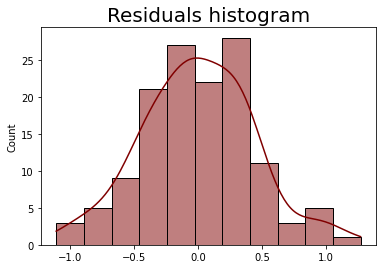

                            OLS Regression Results                            
Dep. Variable:          log_noworodki   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     111.6
Date:                Mon, 12 Jun 2023   Prob (F-statistic):           4.20e-45
Time:                        22:24:01   Log-Likelihood:                -79.569
No. Observations:                 135   AIC:                             171.1
Df Residuals:                     129   BIC:                             188.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         7.7539      0.492     15.773

In [54]:
### diagnostics

final_model = list(models.values())[-1]
name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = sms.het_breuschpagan(final_model.resid, final_model.model.exog)
print(str('-')*50,'\nBP TEST:\n' , lzip(name, test))
print(str('-')*50,'\nRESET TEST:\n' ,ssd.linear_reset(final_model, power=3, test_type='fitted', use_f=False, cov_type='nonrobust', cov_kwargs=None))
print(str('-')*50,'\nJarque Bera TEST:\n' ,scys.jarque_bera(final_model.resid))
x = sns.histplot(final_model.resid, log_scale=False, kde=True, color='maroon')
x.set_title('Residuals histogram', fontdict={'fontsize':20})
plt.show()

### Roboust matrix 
cov_matrix = sm.stats.sandwich_covariance.cov_white_simple(final_model, use_correction=True)

robust_results = final_model.get_robustcov_results(cov_type='HC1')

print(final_model.summary())
print(robust_results.summary())